In [1]:
#%%
import random
import numpy as np
import torch
import torch.utils.data
import glob
import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
import hparams
import os
import matplotlib.pyplot as plt
from pathlib import Path
hparams = hparams.create_hparams()
import warnings
warnings.filterwarnings('ignore')



/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xliu0/anaconda3/envs/taco/lib/python3.6/site-pack

In [2]:
#%%
stft = layers.TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)

print('===========================')
print('filter length', hparams.filter_length)
print('hop_length', hparams.hop_length)
print('win_length', hparams.win_length)
print('n_mel_channels', hparams.n_mel_channels)
print('sampling_rate', hparams.sampling_rate)
print('mel_fmin', hparams.mel_fmin)
print('mel_fmax', hparams.mel_fmax)
print('===========================')


filter length 1024
hop_length 200
win_length 800
n_mel_channels 80
sampling_rate 16000
mel_fmin 0.0
mel_fmax 8000.0


In [3]:
def get_mel(filename, trim = True):
    audio, sampling_rate = load_wav_to_torch(filename, trim=trim)
    if sampling_rate != stft.sampling_rate:
        raise ValueError("{} {} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(melspec, 0)
    melspec = melspec.data.numpy()
    return melspec


def save_spec(data, filepath, output_filename):
    if not(os.path.exists(filepath)):
        Path(filepath).mkdir(parents=True)
    np.save(os.path.join(filepath, output_filename), data)

def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.tight_layout()
    plt.show()


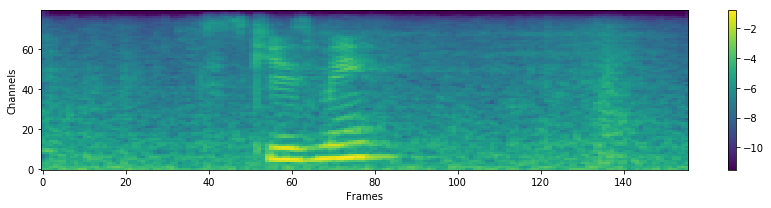

In [14]:
#%% IEMOCAP

SESS_PATH = '/data3/IEMOCAP/IEMOCAP_full_release/Session1/sentences/wav/'
for sess in list(range(1,6)):
    temp_sess_path = SESS_PATH.replace('1', str(sess))
    all_wav_path = sorted(glob.glob(temp_sess_path + '*/*.wav'))
    for wav_path in all_wav_path:
        spec = get_mel(wav_path)
        output_filename = wav_path.split('/')[-1].split('.')[0]
        spec_path = Path(wav_path.replace('IEMOCAP_full_release', 'IEMOCAP_full_release_spec'))
        spec_path = str(spec_path.parent)
        save_spec(spec, spec_path, output_filename)
        plot_spectrogram_to_numpy(spec)
        break
    break
    print('Finished Session ', str(sess))


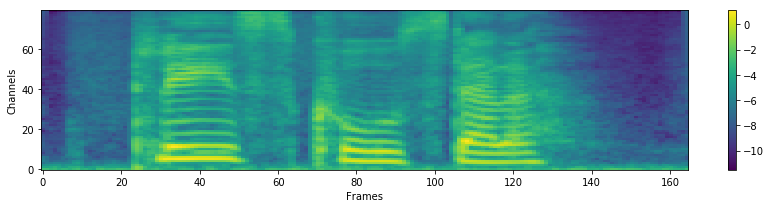

In [15]:
#%% VCTK

VCTK_PATH = '/data3/VCTK/VCTK-Corpus/wav48/'
for wav_path in sorted(glob.glob(VCTK_PATH + '*/*.wav')):
    spec = get_mel(wav_path)
    output_filename = wav_path.split('/')[-1].split('.')[0]
    spec_path = Path(wav_path.replace('/VCTK/', '/VCTK_spec/'))
    spec_path = str(spec_path.parent)
    save_spec(spec, spec_path, output_filename)
    plot_spectrogram_to_numpy(spec)
    break



## Quality check

In [22]:
SESS_PATH = '/data3/IEMOCAP/IEMOCAP_full_release/Session1/sentences/wav/'
for sess in list(range(1,6)):
    temp_sess_path = SESS_PATH.replace('1', str(sess))
    temp_sess_path_spec = temp_sess_path.replace('IEMOCAP_full_release', 'IEMOCAP_full_release_spec')
    all_wav_path = sorted(glob.glob(temp_sess_path + '*/*.wav'))
    all_wav_path_spec = sorted(glob.glob(temp_sess_path_spec + '*/*.npy'))
    if len(all_wav_path) == len(all_wav_path_spec):
        print('That is True')
        
    else:
        prin('Something is wrong!!!!')

That is True
That is True
That is True
That is True
That is True


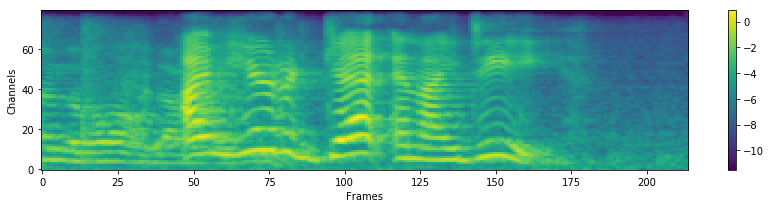

In [4]:
sample_path = '/data3/IEMOCAP/IEMOCAP_full_release_spec/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.npy'
sample_audio = np.load(sample_path)
plot_spectrogram_to_numpy(sample_audio)

(80, 159)


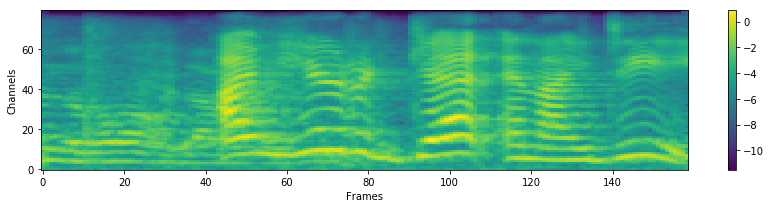

In [5]:
sample_path = '/data3/IEMOCAP/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F008.wav'
spec = get_mel(sample_path)
print(spec.shape)
plot_spectrogram_to_numpy(spec)

### VCTK

In [6]:
VCTK_PATH = '/data3/VCTK/VCTK-Corpus/wav48/'
print(len(sorted(glob.glob(VCTK_PATH + '*/*.wav'))))

VCTK_PATH = '/data3/VCTK_spec/VCTK-Corpus/wav48/'
print(len(sorted(glob.glob(VCTK_PATH + '*/*.npy'))))

44257
44257


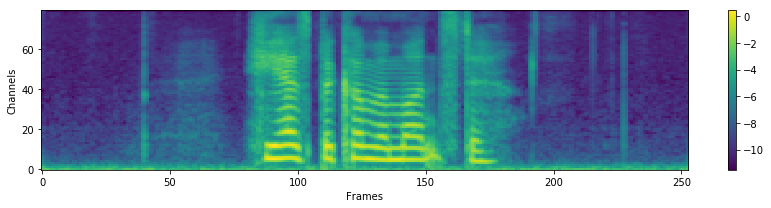

In [7]:
sample_path = '/data3/VCTK_spec/VCTK-Corpus/wav48/p233/p233_105.npy'
sample_audio = np.load(sample_path)
plot_spectrogram_to_numpy(sample_audio)

(80, 150)


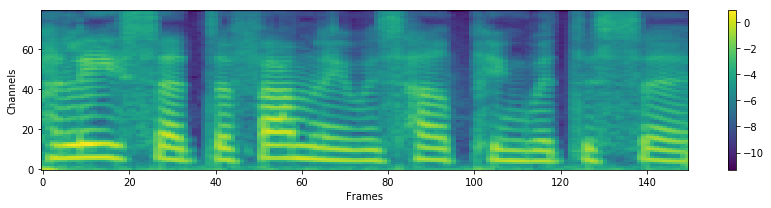

In [8]:
sample_path = '/data3/VCTK/VCTK-Corpus/wav48/p233/p233_103.wav'
spec = get_mel(sample_path)
print(spec.shape)
plot_spectrogram_to_numpy(spec)

(80, 328)


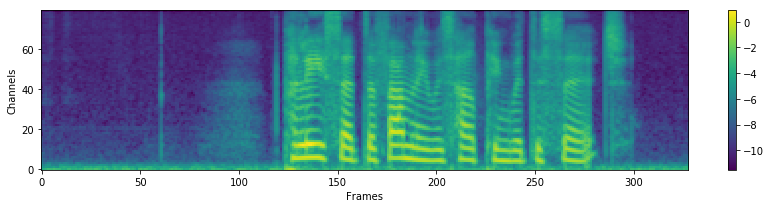

In [9]:
sample_path = '/data3/VCTK/VCTK-Corpus/wav48/p233/p233_103.wav'
spec = get_mel(sample_path, trim=False)
print(spec.shape)
plot_spectrogram_to_numpy(spec)

In [29]:
LJ_PATH = '/data3/LJSpeech-1.1/wavs/'
print(len(sorted(glob.glob(LJ_PATH + '*.wav'))))

LJ_PATH = '/data3/LJSpeech-1.1-spec/wavs/'
print(len(sorted(glob.glob(LJ_PATH + '*.npy'))))


13100
13100
